In [1]:
import numpy as np
import pandas as pd
import pickle5 as pickle
import seaborn as sns
from matplotlib import pyplot
from matplotlib.pyplot import *

import sys
sys.path.append('../')

from NMF_algorithm import NMF_model

from textwrap import wrap

from sklearn.cluster import AgglomerativeClustering

import pyclustering
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer


## Load and visualize data

In [2]:
# Load SYNCQ data

data = pickle.load( open( './SNYCQ_Preproc.pkl', "rb" ) )
data

positive future negative images specific  \
subject    run                                                                  
sub-010014 post-ses-02-run-02-acq-AP     55.0   65.0     60.0   75.0     30.0   
           post-ses-02-run-02-acq-PA     40.0   95.0     55.0   80.0     30.0   
           post-ses-02-run-01-acq-AP     80.0   50.0     15.0   95.0     25.0   
           post-ses-02-run-01-acq-PA     60.0   75.0     10.0   95.0     25.0   
sub-010079 post-ses-02-run-02-acq-AP    100.0   50.0     55.0  100.0    100.0   
...                                       ...    ...      ...    ...      ...   
sub-010077 post-ses-02-run-01-acq-PA     80.0   70.0      5.0   65.0     25.0   
sub-010078 post-ses-02-run-02-acq-AP     60.0   85.0     30.0   60.0     40.0   
           post-ses-02-run-02-acq-PA     55.0   40.0     40.0   60.0     60.0   
           post-ses-02-run-01-acq-AP     65.0   60.0     25.0   55.0     60.0   
           post-ses-02-run-01-acq-PA     85.0   85.0     35.0   55.0     45.0   

                                     people intrusive vigilance myself words  \
subject    run                                                                 
sub-010014 post-ses-02-run-02-acq-AP   60.0      60.0      40.0   50.0  85.0   
           post-ses-02-run-02-acq-PA   60.0      55.0      40.0   55.0  90.0   
           post-ses-02-run-01-acq-AP   65.0      30.0      45.0   30.0  90.0   
           post-ses-02-run-01-acq-PA   65.0      55.0      40.0   65.0  85.0   
sub-010079 post-ses-02-run-02-acq-AP  100.0      35.0      50.0   65.0   5.0   
...                                     ...       ...       ...    ...   ...   
sub-010077 post-ses-02-run-01-acq-PA   80.0       5.0      40.0   15.0  35.0   
sub-010078 post-ses-02-run-02-acq-AP   60.0      40.0      60.0   45.0  15.0   
           post-ses-02-run-02-acq-PA   60.0      40.0      60.0   35.0  15.0   
           post-ses-02-run-01-acq-AP   60.0      25.0      45.0   20.0  25.0   
           post-ses-02-run-01-acq-PA   75.0      40.0      60.0   40.0  15.0   

                                     surroundings  past  
subject    run                                           
sub-010014 post-ses-02-run-02-acq-AP         65.0  40.0  
           post-ses-02-run-02-acq-PA         60.0   5.0  
           post-ses-02-run-01-acq-AP         55.0  55.0  
           post-ses-02-run-01-acq-PA         80.0  70.0  
sub-010079 post-ses-02-run-02-acq-AP         50.0  75.0  
...                                           ...   ...  
sub-010077 post-ses-02-run-01-acq-PA         55.0  75.0  
sub-010078 post-ses-02-run-02-acq-AP         45.0  20.0  
           post-ses-02-run-02-acq-PA         40.0  55.0  
           post-ses-02-run-01-acq-AP         55.0  75.0  
           post-ses-02-run-01-acq-PA         55.0  45.0  

[693 rows x 12 columns]

In [3]:
# Load questions information and class

SNYCQ_Questions = {'positive':'I thought about something positive',
                  'negative':'I thought about something negative', 
                  'future':'I thought about future events',
                  'past':'I thought about past events',
                  'myself':'I thought about myself',
                  'people':'I thought about other people',
                  'surroundings':'I thought about my present environment/surrounding',
                  'vigilance':'I was completely awake',
                  'images':'My thoughts were in the form of images',
                  'words':'My thoughts were in the form of words',
                  'specific':'My thoughts were more specific than vague',
                  'intrusive':'My thoughts were intrusive'}

Form = ['images', 'words','specific','intrusive']
Content = ['positive', 'negative', 'future', 'past', 'myself', 'people', 'surroundings']
Misc = ['vigilance']

SNYCQ_Question_type = {}
for k in SNYCQ_Questions.keys():
    if k in Form:
        SNYCQ_Question_type[k] = 'Form'
    if k in Content:
        SNYCQ_Question_type[k] = 'Content'
    if k in Misc:
        SNYCQ_Question_type[k] = 'Misc'

for k in SNYCQ_Questions:
    print(k + ' : ' + SNYCQ_Questions[k])

positive : I thought about something positive
negative : I thought about something negative
future : I thought about future events
past : I thought about past events
myself : I thought about myself
people : I thought about other people
surroundings : I thought about my present environment/surrounding
vigilance : I was completely awake
images : My thoughts were in the form of images
words : My thoughts were in the form of words
specific : My thoughts were more specific than vague
intrusive : My thoughts were intrusive


In [4]:
# Load data matrix from SYNCQ data

P = data.values.astype('float')
print('Range of data matrix P: [{}, {}]'.format(np.min(P), np.max(P)))

assert np.sum(np.isnan(P)) == 0

Range of data matrix P: [0.0, 100.0]


In [5]:
P.shape

(693, 12)

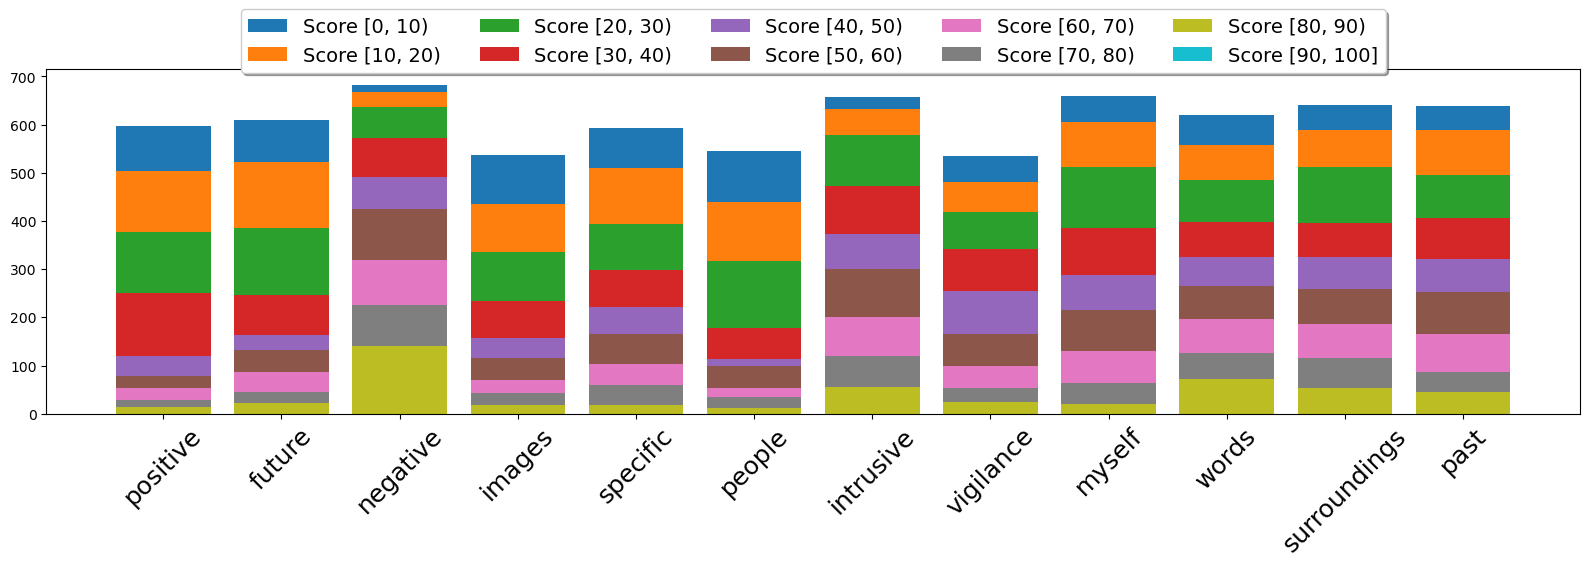

In [6]:
# plot score distribution for each question

fig, ax = pyplot.subplots(figsize=(16,6))
counts = []
for i in range(P.shape[1]):
    counts.append([ np.where( (np.minimum(P[:,i],99) >= j*10) * (np.minimum(P[:,i],99) < (j+1)*10) )[0].shape[0] for j in range(10)])
counts = np.stack(counts)

label_list = []
for i in range(9):
    label_list.append('Score [{}, {})'.format(i*10, (i+1)*10))
label_list.append('Score [{}, {}]'.format(90, 100))

for i in range(10):
    ax.bar(np.linspace(1,P.shape[1],P.shape[1]),np.sum(counts[:,:(9-i)], axis=1), label=label_list[i])

ax.set_xticks(np.linspace(1,P.shape[1],P.shape[1]))
ax.set_xticklabels(data.columns.values, fontsize=18, rotation=45)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          fancybox=True, shadow=True, ncol=5, fontsize=14)
pyplot.tight_layout()
pyplot.show()


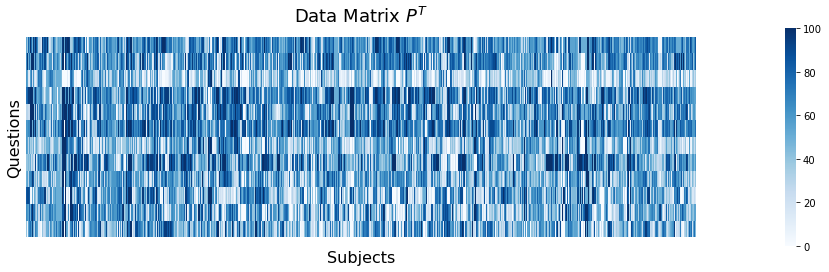

In [29]:
# visualize data matrix

fig, ax = pyplot.subplots(figsize=(16,4))
sns.heatmap(P.T, ax=ax, cmap='Blues', cbar=True, cbar_kws = dict(pad=0.1))
bottom, top = ax.get_ylim()
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Subjects', fontsize=16)
ax.set_ylabel('Questions', fontsize=16)
ax.set_title('Data Matrix $P^T$', fontsize=18)
ax.set_ylim(bottom + 0.5, top - 0.5)
pyplot.show()

## Dimension reduction

In [35]:
# initialize the model

# P : input data matrix
# np.ones_like(P) : the data mask matrix. Since all entries are available. The data mask matrix is of the same
#                   size as P, with all entries = 1
# method='admm' : algorithm that allows incorporating boxed constraint on the embedding
# Wbound=(True, 1.0) : Control the entries of the low dimension representation to be between 0 and 1,
#                      where '1.0' represents the upper bound of the entries
# sparsity_parameter : strength of the sparsity regularizer. Larger the stronger

model = NMF_model(P, np.ones_like(P), 2, method='admm', Wbound=(True, 1.0), sparsity_parameter=0.05)

# ===Remark===
# Although dimension=2 is set, it is obtained by cross-validation method.
# BIC dimension estimation is different from cross-validation.
# The sparsity parameter is fixed and it is often overestimated


In [36]:
model.output_datafile()

In [7]:
W, Q = model.decomposition()

NameError: name 'model' is not defined

## Visualize results

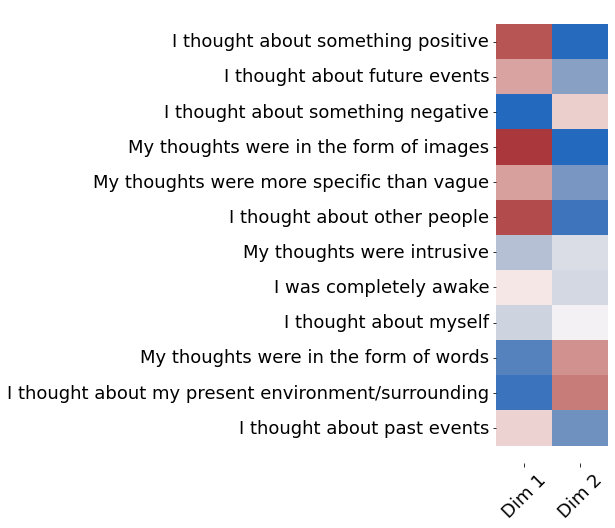

In [38]:
def plot_Q(Q, SNYCQ_Questions):
    nQ = Q.shape[0]
    k = Q.shape[1]
#     questions = list(NYCQ_Questions.values())
    questions = [SNYCQ_Questions[label] for label in data.columns.values]
    wrap_questions = [ '\n'.join(wrap(l, 100)) for l in questions ]

    fig, ax = pyplot.subplots(figsize=(k, 0.7*nQ))
    sns.heatmap(Q, cmap='vlag', ax=ax, cbar=False, cbar_kws = dict(pad=0.1))
    ax.set_yticks(np.arange(nQ)+0.5)
    ax.set_yticklabels(wrap_questions, fontsize=18, rotation=0)
    ax.set_xticks(np.linspace(0+0.5, k-0.5, k))
    ax.set_xticklabels(['Dim {}'.format(i+1) for i in range(k)], fontsize=18, rotation=45)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    pyplot.show()
    
plot_Q(Q, SNYCQ_Questions)

In [39]:
def plot_Q(Q, SNYCQ_Questions, kinit = 2, kmax = 10):
    
    nQ = Q.shape[0]
    k = Q.shape[1]
    question_list = [SNYCQ_Questions[label] for label in data.columns.values]
    type_list = [SNYCQ_Question_type[label] for label in data.columns.values]
    wrap_question_list = [ '\n'.join(wrap(l, 100)) for l in question_list ]
    

    fig = pyplot.figure(figsize=(16,0.45*nQ))
    gs = matplotlib.gridspec.GridSpec(1,k,figure=fig)

    color_code = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
                  'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

    upper_quantile = 0.7
    
    for d in range(k):
        factor = Q[:,d]

        factor_load = []
        factor_question = []
        factor_type = []
        factor_count = []
        factor_color = []
        type_color = []
        
        for (i, question) in enumerate(wrap_question_list[:nQ]):
            factor_load.append(factor[i])
            factor_type.append(type_list[i])
            factor_question.append(question)
            if factor[i] > np.quantile(factor[factor>0], upper_quantile):
                factor_color.append('tab:red')
            else:
                factor_color.append('tab:gray')
            if type_list[i] == 'Form':
                type_color.append('tab:brown')
            elif type_list[i] == 'Content':
                type_color.append('tab:green')
            elif type_list[i] == 'Misc':
                type_color.append('k')
                
        ax = fig.add_subplot(gs[0,d])

        ax.barh(np.linspace(0,nQ-1,nQ), np.asarray(factor_load),
                color=factor_color, alpha=0.5,
                tick_label=factor_question)
        
        if d == 0:
            for t in range(len(factor_question)):
                ax.get_yticklabels()[t].set_color(type_color[t])
        else:
#             ax.set_yticks([])
            ax.set_yticklabels([])
            
        ax.grid(alpha=0.5)
        ax.invert_yaxis()

        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.tick_params(axis='y', labelsize=16)
        ax.set_title('Factor {}'.format(d+1), fontsize=16)
        
        ax.set_ylim([0-0.5, nQ-0.5])
        ax.vlines(np.quantile(factor[factor>0], upper_quantile), -0.5, nQ-0.5, colors='gray', linestyles='dashed',linewidth=1)

    fig.suptitle('', fontsize=16, y=0.92)
    pyplot.tight_layout()
    pyplot.show()
    
    k = Q.shape[1]
    initial_centers = kmeans_plusplus_initializer(Q, kinit).initialize()
    xmeans_instance = xmeans(Q, initial_centers, kmax)
    xmeans_instance.process()
    clusters = xmeans_instance.get_clusters()
    label = np.zeros(Q.shape[0])
    for k in range(len(clusters)): label[clusters[k]] = k
    k = len(clusters)
    
    return label
                    

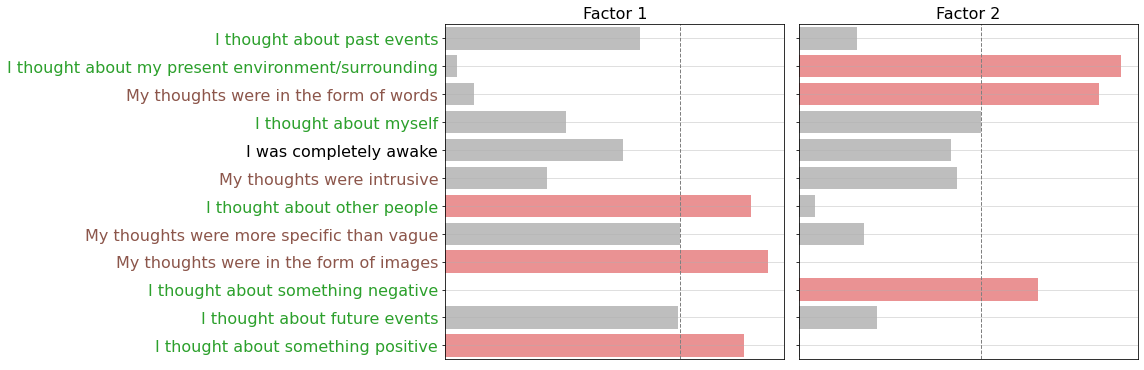

In [40]:
# Plot of the question embedding

Q_label = plot_Q(Q, SNYCQ_Questions)

In [41]:
def plot_W(W, nGroup=None, kinit=2, kmax=10):
    
    
    k = W.shape[1]
    if nGroup is None:
        nGroup = k
        
        initial_centers = kmeans_plusplus_initializer(W, kinit).initialize()
        xmeans_instance = xmeans(W, initial_centers, kmax)
        xmeans_instance.process()
        clusters = xmeans_instance.get_clusters()
        label = np.zeros(W.shape[0])
        for k in range(len(clusters)): label[clusters[k]] = k
        k = len(clusters)
            
    else:
        clustering = AgglomerativeClustering(n_clusters=nGroup).fit(W)
        label = clustering.labels_
        
    
    jump = np.where(np.sort(label)[1:]-np.sort(label)[:-1] > 0)[0]
    center = np.append(jump,label.shape[0])
    diff = (center[1:] - center[:-1])/2
    center = center - np.append(center[0]/2, diff)
    
    fig, ax = pyplot.subplots(figsize=(16,0.5*k))
    sns.heatmap((W[np.argsort(label),:]).T, cmap='Blues', ax=ax, cbar=False)
    ax.set_yticks(np.arange(W.shape[1])+0.5)
    ax.set_yticklabels(['Dim {}'.format(i+1) for i in range(k)], rotation=0, fontsize=14)
    ax.set_xticks([])
    ax.set_xlabel('Sorted subjects', fontsize=16)
    for (i, loc) in enumerate(jump):
        ax.vlines(loc+1,0-0.5,W.shape[1], color='r')
    for (i, loc) in enumerate(center):
        ax.text(loc, -0.5, 'Group {}'.format(i+1), ha='left', rotation=45, fontsize=14)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    pyplot.show()
    
    return label


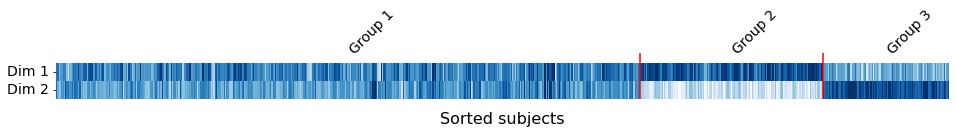

In [42]:
# plot of the subject embedding
# 'nGroup=4' : cluster the subjects into 3 groups. If nGroup='None', xmean clustering be employed

W_label = plot_W(W, nGroup=3)

In [43]:
def plot_subject_group(P, Q_label, W_label):
        
    
    jump = np.where(np.sort(W_label)[1:]-np.sort(W_label)[:-1] > 0)[0]
    center = np.append(jump,W_label.shape[0])
    diff = (center[1:] - center[:-1])/2
    center = center - np.append(center[0]/2, diff)
    
    fig, ax = pyplot.subplots(figsize=(16,4))
    sns.heatmap((P[np.argsort(W_label),:][:, np.argsort(Q_label)]).T, cmap='Blues', ax=ax, cbar=False)
    ax.set_yticks([])
    ax.set_ylabel('Sorted Questions', fontsize=16)
    ax.set_xticks([])
    ax.set_xlabel('Sorted subjects', fontsize=16)
    for (i, loc) in enumerate(jump):
        ax.vlines(loc+1,0-0.5,P.shape[1], color='r')
    for (i, loc) in enumerate(center):
        ax.text(loc, -0.5, 'Group {}'.format(i+1), ha='left', rotation=45, fontsize=14)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    pyplot.show()
    
#     fig.savefig("./visualization/M-clusters-form.pdf", bbox_inches='tight')

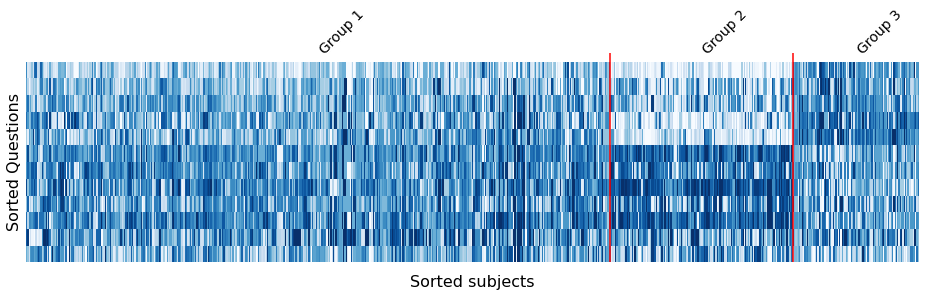

In [44]:
plot_subject_group(P, Q_label, W_label)